In [2]:
def gap(V, delta, Z, broadness, offset=0):
    def ingap(E, delta):
        return E <= delta

    def u2(E, delta): #u0 squared, BCS coefficient
        return .5 * (1+np.sqrt((E**2 - delta**2)/E**2))

    def v2(E, delta): # v0 squared, BCS coefficient
        return (1-u2(E, delta))

    def gamma2(E, delta, Z): # gamma squared
        return (u2(E, delta) + (Z**2)*(u2(E, delta) - v2(E, delta)))**2

    def A(E, delta, Z):
        if E <= delta:
            return delta**2/(E**2 + (delta**2 - E**2)*(1+2*Z**2)**2)
        if E > delta:
            return (u2(E, delta)*v2(E, delta))/gamma2(E, delta, Z)

    def B(E, delta, Z):
        if E < delta:
            return 1 - delta**2/(E**2 + (delta**2 - E**2)*(1+2*Z**2)**2)
        if E >= delta:
            return ((u2(E, delta)-v2(E, delta))**2*Z**2*(1+Z**2))/gamma2(E, delta, Z)

    def f0_deriv(expo):
        return ((c/(k*T))*expo)/(expo+1)**2

    def f0(expo):
        return 1/(expo+1)

    def per_e(e, v, delta, Z, broadness):
        expo_f = exp(v)
        expo_f_deriv = exp(e-c*v)
        return (f0_deriv(expo_f_deriv)-f0(expo_f))*(1 + A(e, delta, Z)-B(e, delta, Z))

    def exp(E):
        return np.exp(np.real(E)/(k*T))

    def DIDV(V, delta, Z, broadness):
        return np.sum(np.array([np.real(per_e(e+1j*broadness, V, delta, Z, broadness)) for e in E])  /len(E))

    #Rn = .5*norm(delta)
    #return scale*(1/Rn)*np.array([DIDV(abs(v-offset)) for v in V]) data not well normalized
    norm= 2/DIDV(0, delta, 0, 0)
    return np.array([norm * DIDV(abs(v-offset), delta, Z, broadness) for v in V])

In [4]:
k= 8.617e-5 #eV/K Boltzmann
T= 55e-3 #temp of 1 mK
c=1
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import time
import smtplib


def mail(subject_matter, body):
    gmail_user = 'pistockmail@gmail.com'
    gmail_password = 'stockpiticker'
    sent_from = gmail_user
    to = 'david@vdriel.nl'
    subject = 'Update about '+str(subject_matter)
    email_text = body
    message = 'Subject: {}\n\n{}'.format(subject, email_text)
    try:
        server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
        server.ehlo()
        server.login(gmail_user, gmail_password)
        server.sendmail(sent_from, to, message)
        server.close()
    except:
        print ('Something went wrong...')



def dataload(filename = '', column = 0):
    G0 = 12906
    factor = 1e-6 #1mV/V unit is now millivolts
    data = np.loadtxt(filename+".dat")
    lines = open(filename + ".meta.txt").read().splitlines()
    x,y = lines[3], lines[7] #y is fixed as x is sweeped, the y up
    len_x, len_y = int(lines[0]), int(lines[4]) #So, column x sweeped first
    datavalues = [x,y,"z", 'valueK1','valueK2','valueK3','valueL1','valueL2',0,'K1','K2','K3','RL1','thetaL1','RL2','thetaL2',0,0]

    def ind(st):
        return datavalues.index(st)

    def f(n):
        return n*len_x



    if len_y == 1:
        Vbias = factor * data[:, ind(x)] -7272 * data[:, ind('valueK1')]


        g = G0*data[:, ind('valueL1')]
    else:
        BG_datapoint = f(column)
        Vbias = factor * data[BG_datapoint : BG_datapoint + len_x, ind(x)] \
                -7272*data[BG_datapoint : BG_datapoint + len_x, ind('valueK1')]
        g = G0*data[BG_datapoint : BG_datapoint + len_x, ind('valueL1')]
        print(("BG = "+str(data[f(column),ind(y)] )))
    return Vbias, g

Vn, gn = dataload('2.1&3.1_R-M_8', 261)
#V, delta = 2e-4, Z = 1.0, broadness = 0.01
p0 = ( 2.15e-04, 1.6, 3.5e-5)
popt=p0
E = np.arange(1.2*min(Vn),1.2*max(Vn), 1.0000001e-5)
start = time.time()
#popt, pcov = curve_fit(gap, Vn, gn, p0 = p0)
#plt.plot(Vn, gap(Vn, *popt), label="Fit")
plt.scatter(Vn, gn, s=1, label="Data")
plt.xlim(-.5e-3,.5e-3)
#plt.ylim(0,2)
plt.title('as')

#plt.plot(Vn, gap(Vn, delta = popt[0], Z = popt[2], broadness = popt[4]), label = "gap1")
#plt.plot(Vn, gap(Vn, delta = popt[1], Z = popt[3], broadness = popt[5]), label = "gap2")
plt.legend()

plt.show()


BG = 165.25


<Figure size 640x480 with 1 Axes>

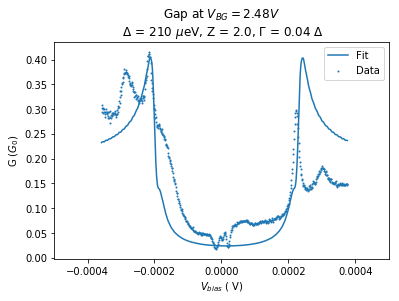

In [109]:
plt.plot(Vn, gap(Vn, *popt), label="Fit")
plt.scatter(Vn, gn, s=1, label="Data")
plt.xlim(-.5e-3,.5e-3)
plt.title('Gap at $V_{BG} = 2.48 V$ \n $\Delta$ = ' + 
          str(int(1000000 * popt[0])) + " $\mu $eV, Z = " + str(round(popt[1],1)) +
         ", $\Gamma$ = " + str(round(popt[2]/popt[0],2)) + " $\Delta$")
plt.xlabel(r"$V_{bias}$ ( V)")
plt.ylabel("G ($G_0$)")
#plt.plot(Vn, gap(Vn, delta = popt[0], Z = popt[2], broadness = popt[4]), label = "gap1")
#plt.plot(Vn, gap(Vn, delta = popt[1], Z = popt[3], broadness = popt[5]), label = "gap2")
plt.legend()

#plt.show()
plt.savefig("BTK_fit_2.1_second.png", dpi=300)

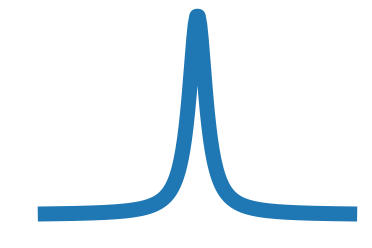

In [121]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)
x = np.linspace(0,3,200)
plt.plot(x, lorentzian(x,1.5,1,.1), linewidth=15)
plt.axis('off')
plt.savefig("Tunnelbarrier.png", transparent=True)

BG = 165.0
BG = 165.25
BG = 165.5
BG = 165.75
BG = 166.0
BG = 166.25
BG = 166.5
BG = 166.75
BG = 167.0
BG = 167.25
BG = 167.5
BG = 167.75
BG = 168.0
BG = 168.25
BG = 168.5
BG = 168.75
BG = 169.0
BG = 169.25
BG = 169.5
BG = 169.75
BG = 170.0
BG = 170.25
BG = 170.5
BG = 170.75
BG = 171.0
BG = 171.25
BG = 171.5
BG = 171.75
BG = 172.0
BG = 172.25


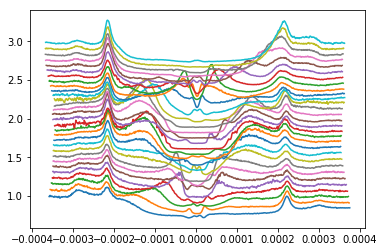

In [133]:
for i in range(260,290,1):
    Vn, gn = dataload('2.1&3.1_R-M_8', i)
    plt.plot(Vn,gn+(i-250)*.07)
plt.savefig("doublegap_waterfall.png",dpi=300)

In [132]:
plt.show()

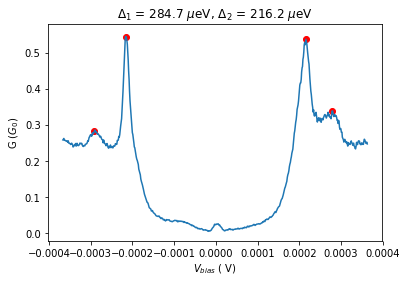

In [192]:
plt.plot(Vn,gn)
for i in [65,527,130,471]:
    plt.scatter(Vn[i], gn[i], c = 'r')
plt.xlabel(r"$V_{bias}$ ( V)")
plt.ylabel("G ($G_0$)")
plt.title("$\Delta_1$ = " + str(round(1e6*(abs(Vn[65])+abs(Vn[527]))/2,1))+" $\mu$eV, " +
         "$\Delta_2$ = " + str(round(1e6*(abs(Vn[130])+abs(Vn[471]))/2,1))+" $\mu$eV")
plt.savefig("Doublegap_linecut.png", dpi=300)

In [180]:
print(Vn[65])
print(Vn[527])
print(Vn[130])
print(Vn[471])

-0.00029102868707554
0.0002783685450855
-0.00021640080142862
0.00021608352434855998


In [137]:
argrelextrema(gn, np.greater)

(array([  2,   4,   8,  11,  18,  24,  26,  29,  35,  38,  43,  51,  56,
         58,  61,  66,  69,  72,  77,  84,  91,  95,  98, 101, 105, 108,
        112, 115, 131, 184, 193, 196, 201, 206, 210, 213, 215, 219, 225,
        229, 236, 240, 243, 248, 257, 260, 265, 269, 274, 278, 281, 283,
        287, 298, 301, 304, 307, 319, 321, 325, 327, 330, 334, 336, 340,
        345, 347, 350, 352, 354, 357, 360, 363, 369, 378, 385, 387, 390,
        393, 398, 408, 468, 471, 488, 493, 499, 502, 506, 512, 519, 521,
        524, 528, 533, 535, 539, 541, 545, 548, 554, 558, 561, 567, 572,
        578, 582, 584, 586, 589, 591, 594, 599]),)

In [10]:
def two_gap(V, delta1 = 2e-4, delta2 = 2e-4, Z1 = 1.0, Z2 = 1.0, broadness1 = 1e-6, broadness2 = 1e-6, w = .5):
    offset = 0
    def ingap(E, delta):
        return E <= delta

    def u2(E, delta): #u0 squared, BCS coefficient
        return .5 * (1+np.sqrt((E**2 - delta**2)/E**2))

    def v2(E, delta): # v0 squared, BCS coefficient
        return (1-u2(E, delta))

    def gamma2(E, delta, Z): # gamma squared
        return (u2(E, delta) + (Z**2)*(u2(E, delta) - v2(E, delta)))**2

    def A(E, delta, Z):
        if E <= delta:
            return delta**2/(E**2 + (delta**2 - E**2)*(1+2*Z**2)**2)
        if E > delta:
            return (u2(E, delta)*v2(E, delta))/gamma2(E, delta, Z)

    def B(E, delta, Z):
        if E < delta:
            return 1 - delta**2/(E**2 + (delta**2 - E**2)*(1+2*Z**2)**2)
        if E >= delta:
            return ((u2(E, delta)-v2(E, delta))**2*Z**2*(1+Z**2))/gamma2(E, delta, Z)

    def f0_deriv(expo):
        return ((c/(k*T))*expo)/(expo+1)**2

    def f0(expo):
        return 1/(expo+1)

    def per_e(e, v, delta, Z, broadness):
        expo_f = exp(v)
        expo_f_deriv = exp(e-c*v)
        return (f0_deriv(expo_f_deriv)-f0(expo_f))*(1 + A(e, delta, Z)-B(e, delta, Z))

    def exp(E):
        return np.exp(np.real(E)/(k*T))

    def DIDV(V, delta, Z, broadness):
        return np.sum(np.array([np.real(per_e(e+1j*broadness, V, delta, Z, broadness)) for e in E])  /len(E))

    #Rn = .5*norm(delta)
    #return scale*(1/Rn)*np.array([DIDV(abs(v-offset)) for v in V]) data not well normalized
    norm1, norm2 = 2/DIDV(0, delta1, 0, 0), 2/DIDV(0, delta2, 0, 0)
    return np.array([w * norm1 *DIDV(abs(v-offset), delta1, Z1, broadness1) +
                     (1-w) * norm2 *DIDV(abs(v-offset), delta2, Z2, broadness2) for v in V])

In [212]:

#p0 = (2.58e-4, 2.16e-4, 1.0,1.0, 1e-6, 1e-6, .5)
popt, pcov = curve_fit(two_gap, Vn, gn, p0 = popt, bounds = (
    (2.4e-4,2e-4,0,0,0,0,0),
    (2.7e-4,2.4e-4,2,2,1e-4,1e-4,1)
    ))

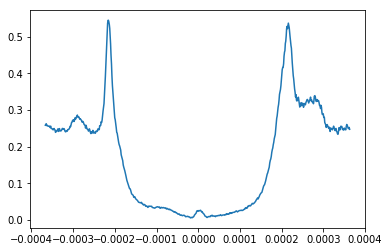

In [209]:
plt.plot(Vn, gn)

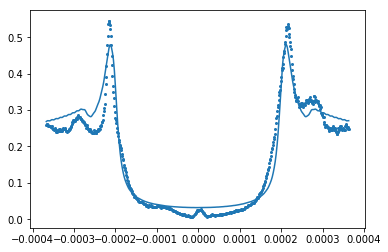

In [213]:
plt.plot(Vn, two_gap(Vn, *popt))
plt.scatter(Vn, gn, s =4)
#plt.savefig("bestdoublegap.png", dpi=300)

Text(0.5, 1.0, '$\\Delta_1$, $\\Delta_2$ = 253.4, 204.3 $Z_1$, $Z_2$ = 1.98, 1.8 $\\Gamma_1$, $\\Gamma_2$ = 0.3945 $\\Delta_1$, 0.0135$\\Delta_2$')

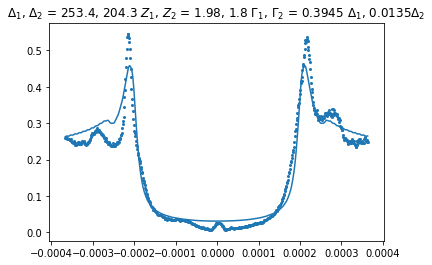

In [13]:
plt.plot(Vn, two_gap(Vn, *popt))
plt.scatter(Vn, gn, s =4)
plt.title(r'$\Delta_1$, $\Delta_2$ = '+ str(round(1e6*popt[0], 1)) +", " +str(round(1e6*popt[1], 1)) +
          r' $Z_1$, $Z_2$ = '+ str(round(popt[2], 3)) + ", " +str(round(popt[3], 1)) +
          r' $\Gamma_1$, $\Gamma_2$ = '+ str(round(popt[4]/popt[0], 4)) + " $\Delta_1$, " + 
          str(round(popt[5]/popt[1], 4)) + "$\Delta_2$"
          )
#plt.savefig("bestdoublegap.png", dpi=300)

BG = 172.25


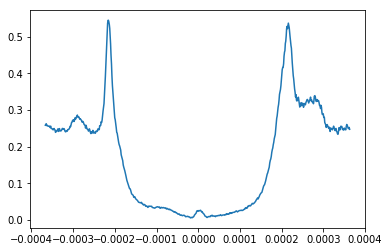

In [219]:
Vn, gn = dataload('2.1&3.1_R-M_8', 289)
plt.plot(Vn,gn)

In [15]:
gap([0], .1, 1, 0)

array([0.22306373])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


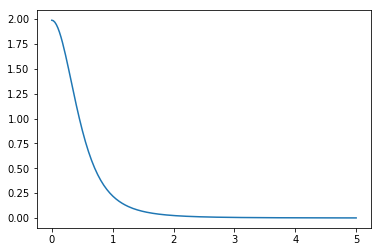

In [80]:
Zs = np.linspace(0,5,200)

subgaps = np.zeros(200)
normals = np.zeros(200)
for i in range (len(Zs)):
    E = np.arange(-6e-4,6e-4, 1.0000001e-5)
    subgaps[i] = gap([0], 4e-4, Zs[i], 0)
    E = np.arange(1e-4,9e-3, 1.0000001e-5)
    normals[i] = gap([8e-3], 1e-5, Zs[i], 0)
plt.plot(Zs, subgaps)
plt.plot(Zs, normals)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


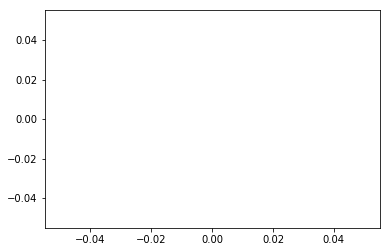

In [90]:
E = np.arange(-4e-3,4e-3, 1.0000001e-5)
for i in range (len(Zs)):
    normals[i] = gap([1e-5], 1e-7, Zs[i], 0)
plt.plot(Zs, normals)

In [87]:
normals

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [105]:
two_gap(Vn, 1e-4, 1e-4, 1, 1e-6, 1e-6, 0.5)

array([0.75991306, 0.76144402, 0.76192712, 0.76125875, 0.75961905,
       0.75796765, 0.7572717 , 0.75771735, 0.75934974, 0.76109123,
       0.76220617, 0.76233642, 0.76130196, 0.75960278, 0.75822947,
       0.75779045, 0.75854643, 0.75993336, 0.76166309, 0.76280741,
       0.76283641, 0.76179678, 0.76013863, 0.75873183, 0.75838721,
       0.75919688, 0.76087222, 0.76267006, 0.76355902, 0.76324272,
       0.76191542, 0.76022866, 0.75914303, 0.75912689, 0.76041006,
       0.76238553, 0.76382807, 0.76425336, 0.7635667 , 0.76199623,
       0.76051784, 0.7597045 , 0.76013461, 0.76147783, 0.76323432,
       0.7646864 , 0.76495083, 0.76416821, 0.76257908, 0.7611204 ,
       0.7604625 , 0.76094493, 0.76246891, 0.76429069, 0.76548632,
       0.76580242, 0.76498946, 0.76335652, 0.76200676, 0.76134755,
       0.76178695, 0.76329544, 0.76491963, 0.76630148, 0.76674936,
       0.76591873, 0.76460313, 0.76310745, 0.76233079, 0.76261143,
       0.76400355, 0.7658052 , 0.76731481, 0.76780801, 0.76720

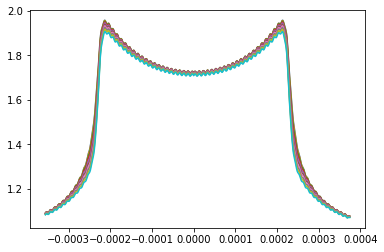

In [14]:
E = np.arange(1.2*min(Vn),1.2*max(Vn), 1.0000001e-5)
for j in range (10):
    A = two_gap(Vn, 2.25e-4, 2.25e-4, .3, 0.0, j*6e-6, 0)
    plt.plot(Vn, A)
#A = two_gap(Vn, 2.25e-4, 2.25e-4, 1, 0.0, 0.0, 0.0)
#plt.plot(Vn, A)

BG = 172.25


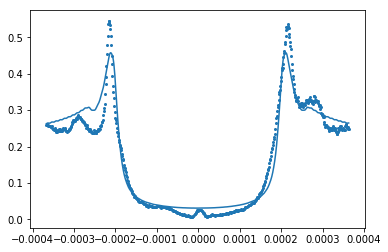

In [11]:
Vn, gn = dataload('2.1&3.1_R-M_8', 289)
p0 = (2.58e-4, 2.16e-4, 1.0,1.0, 1e-6, 1e-6, .5)
popt, pcov = curve_fit(two_gap, Vn, gn, p0 = p0, bounds = (
    (2.4e-4,2e-4,0,0,0,0,0),
    (2.7e-4,2.4e-4,2,2,1e-4,1e-4,1)
    ))
plt.plot(Vn, two_gap(Vn, *popt))
plt.scatter(Vn, gn, s =4)
#plt.savefig("bestdoublegap.png", dpi=300)
#def two_gap(V, delta1 = 2e-4, delta2 = 2e-4, Z1 = 1.0, Z2 = 1.0, broadness1 = 1e-6, broadness2 = 1e-6, w = .5):

In [ ]:
plt.plot(Vn, two_gap(Vn, *popt))
plt.scatter(Vn, gn, s =4)
plt.title(r'$\Delta_1$, $\Delta_2$ = '+ str(round(1e6*popt[0], 1)) +", " +str(round(1e6*popt[1], 1)) +
          r' $Z_1$, $Z_2$ = '+ str(round(popt[2], 3)) + ", " +str(round(popt[3], 1)) +
          r' $\Gamma_1$, $\Gamma_2$ = '+ str(round(popt[4]/popt[0], 4)) + " $\Delta_1$, " + 
          str(round(popt[5]/popt[1], 4)) + "$\Delta_2$"
          )

In [12]:
popt

array([2.53373177e-04, 2.04260671e-04, 1.98020936e+00, 1.84510602e+00,
       9.99660899e-05, 2.76242803e-06, 2.01660354e-01])